In [20]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)

import tensorflow.keras as keras

x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

import pandas as pd
import numpy as np
from numpy.fft import fft


import librosa
from librosa.display import specshow
from librosa import feature
from librosa.core import load

from glob import glob
import os
import sys
from zipfile import ZipFile
import urllib

from IPython.display import Audio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from pydub import AudioSegment
import wave


from scipy.io.wavfile import read as read_wav
import pickle
from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing

import sklearn.datasets as datasets

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression as lr

sounds_dir = "xeno-canto-ca-nv/"

def fullPath(sample): return os.path.join(sounds_dir, sample['file_name'])

df = pd.read_csv("xeno-canto_ca-nv_index.csv")
df.columns = np.append('id', df.columns[1:None])#label first col as id
files_list = glob(os.path.join(sounds_dir,"*.mp3"))

print("%i mp3 files in %s"%(len(files_list), sounds_dir))
print("%i samples in index."%len(df))
df = df.drop(['country', 'license', 'remarks', 'recordist', 'recordist_url', 'location', 'english_cname', 'file_url'], axis = 1)
df.head()


f = open('songData.pickle','rb')
X = pickle.load(f)
f.close()

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True


c:\users\ian\appdata\local\programs\python\python38\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


2730 mp3 files in xeno-canto-ca-nv/
2730 samples in index.


In [21]:
# generate class feature for easy supervised learning in sklearn
makeClass = lambda a, label: 1 if a.lower().find(label.lower()) != -1 else 0
makeClass = np.vectorize(makeClass)

y = np.hstack((np.array([makeClass(df['type'].values, 'song')]).T, np.array([makeClass(df['type'].values, 'call')]).T, np.array([makeClass(df['type'].values, 'alarm call')]).T)) #class feature is song/notsong
print(y)

[[0 1 0]
 [0 1 0]
 [0 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 1 0]]


[1. 1. 1. ... 1. 1. 1.]


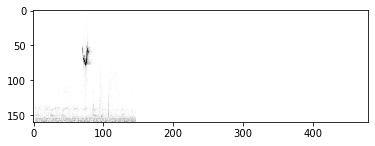

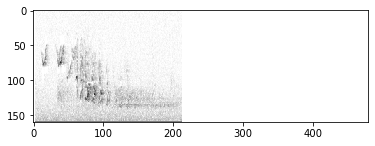

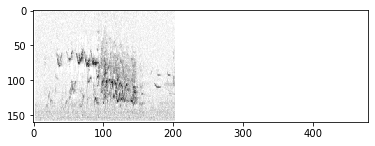

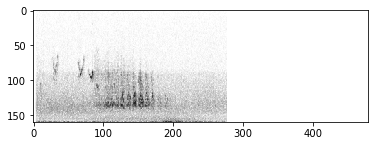

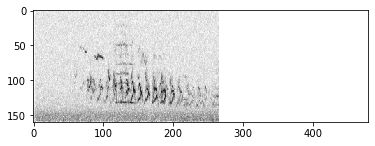

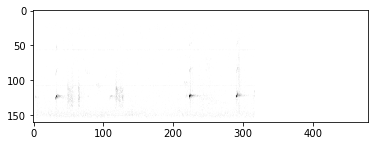

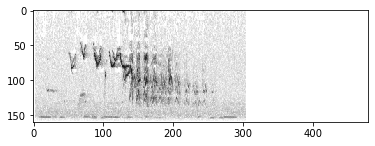

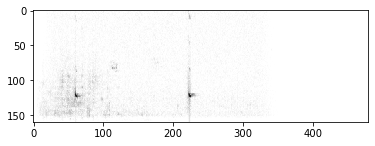

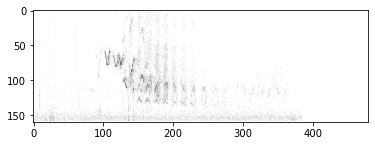

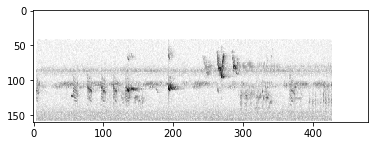

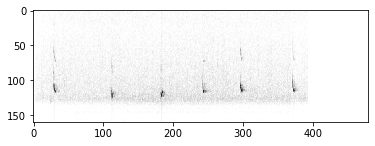

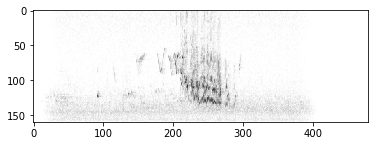

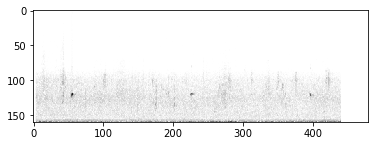

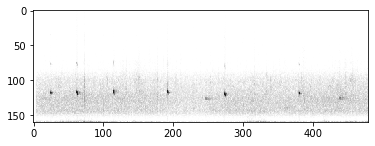

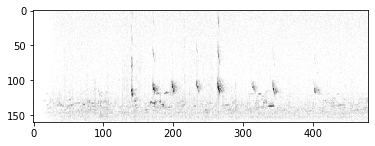

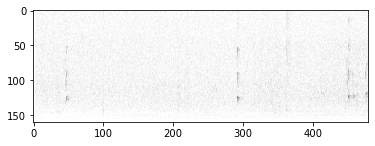

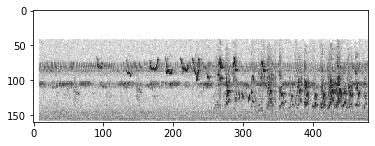

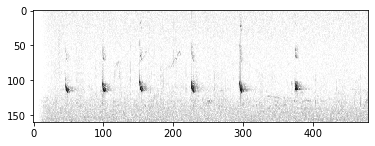

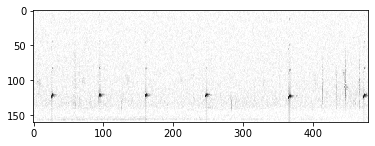

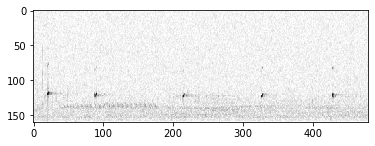

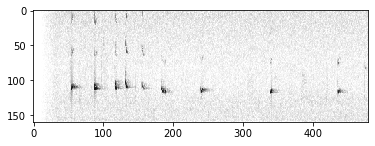

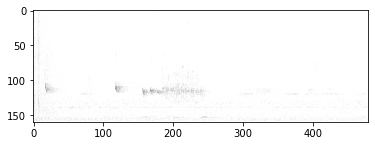

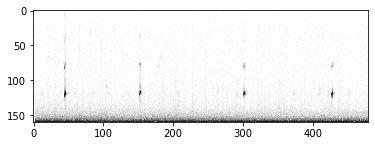

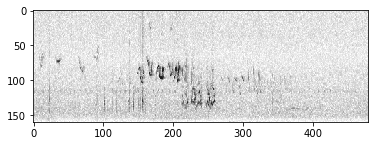

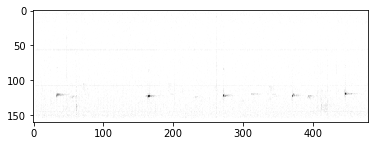

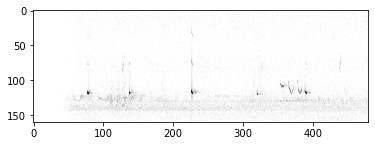

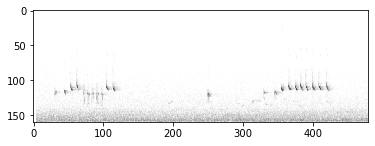

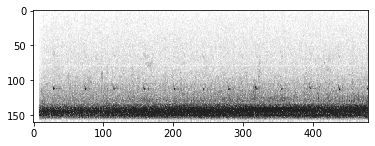

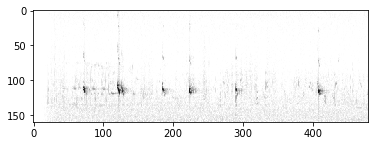

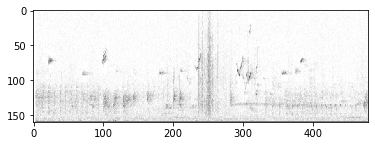

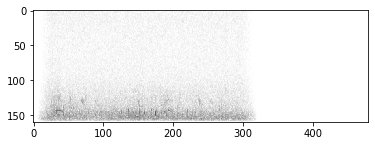

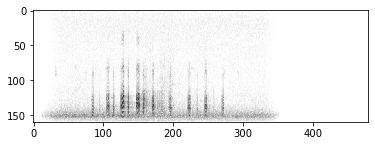

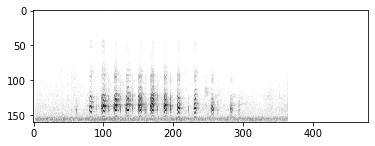

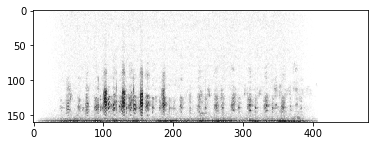

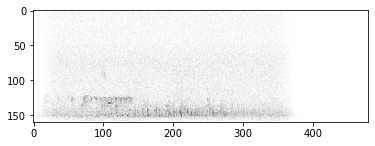

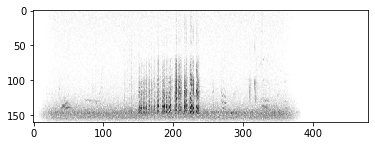

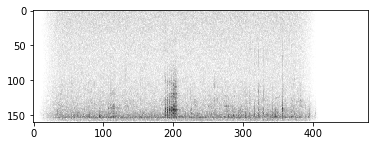

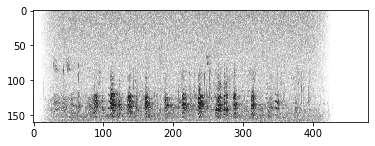

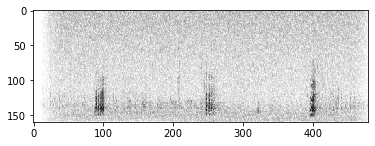

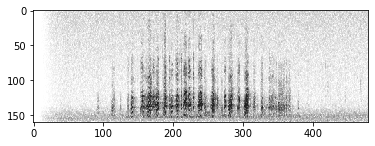

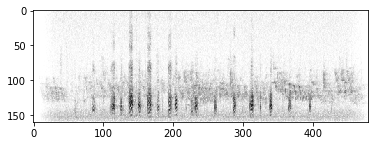

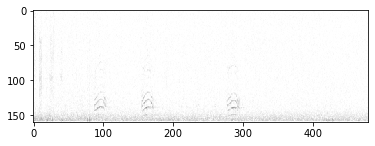

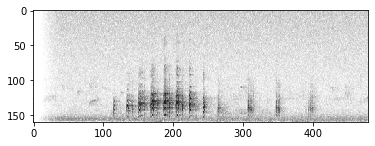

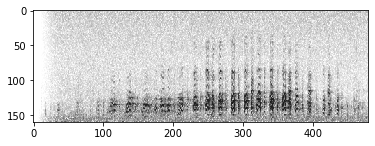

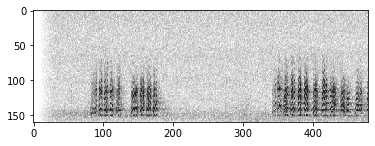

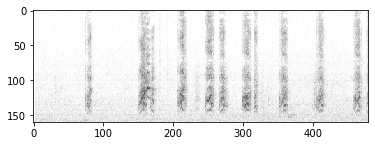

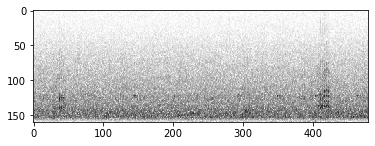

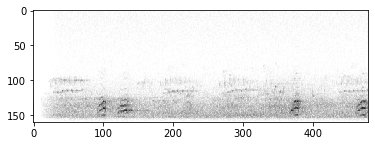

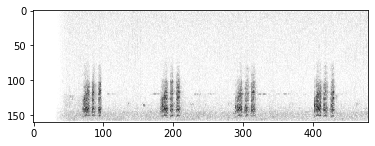

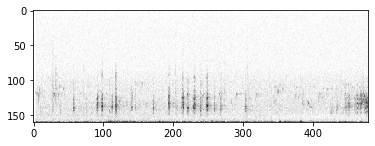

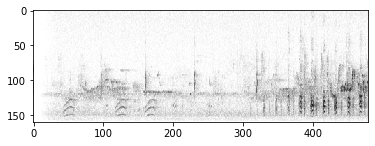

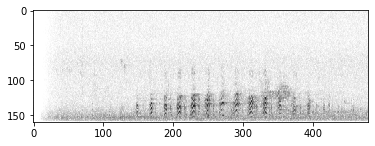

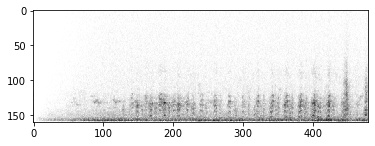

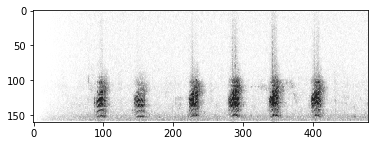

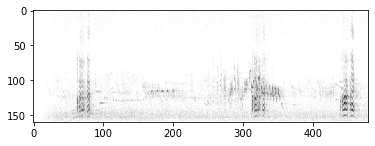

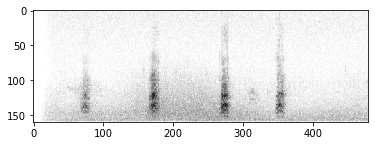

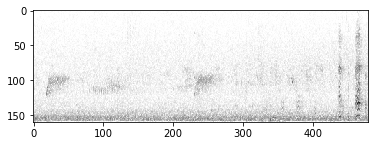

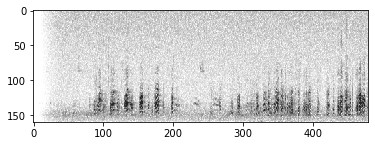

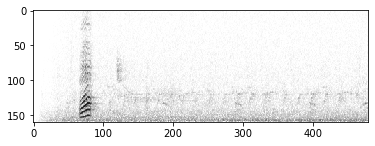

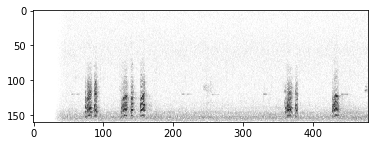

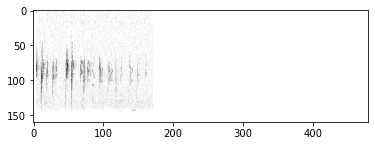

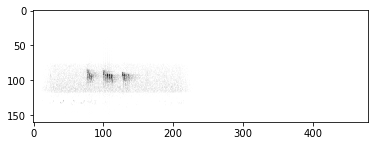

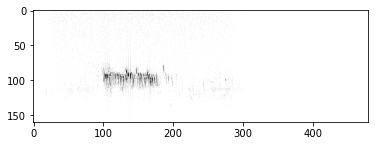

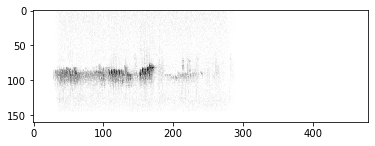

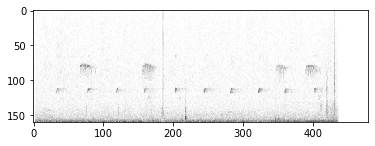

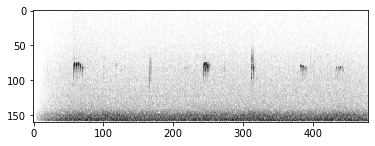

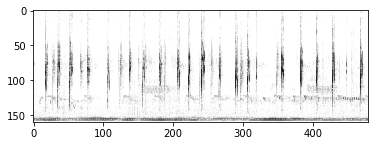

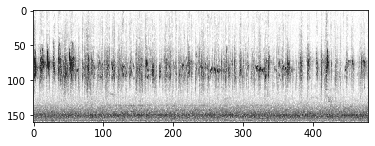

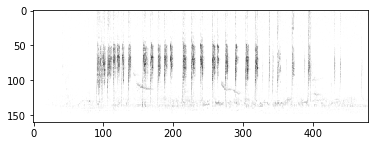

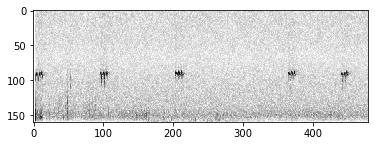

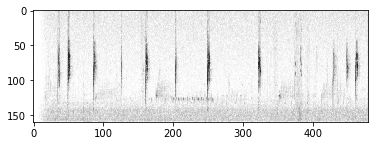

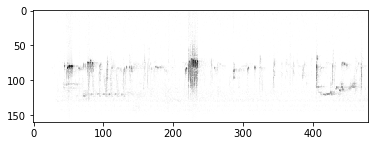

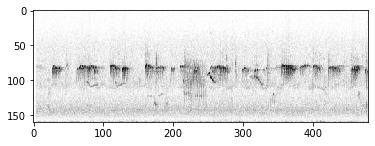

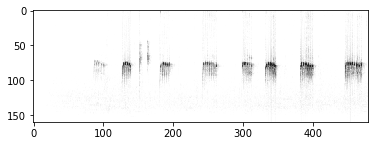

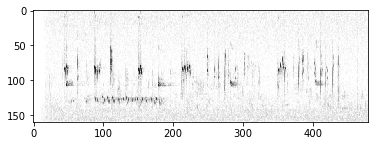

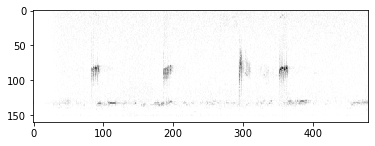

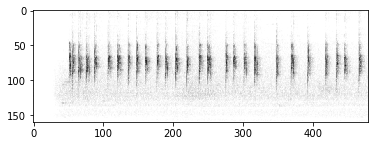

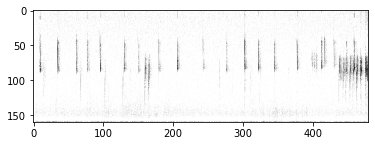

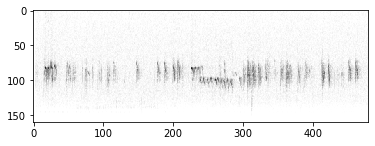

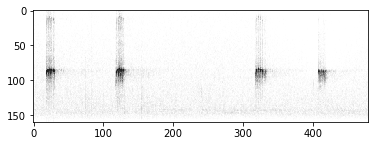

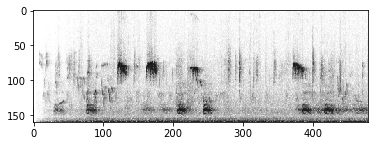

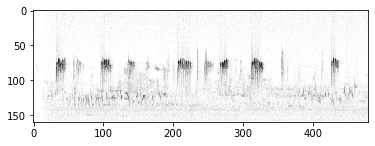

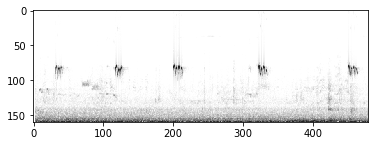

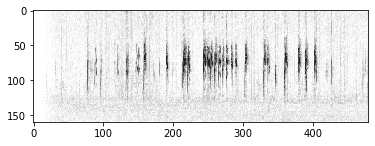

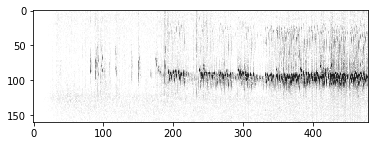

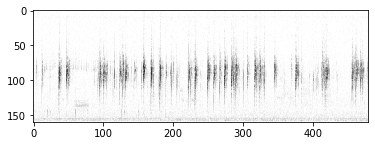

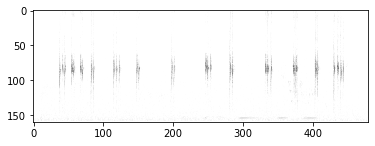

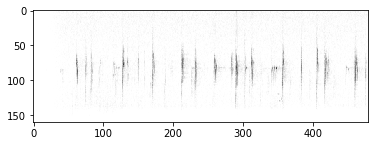

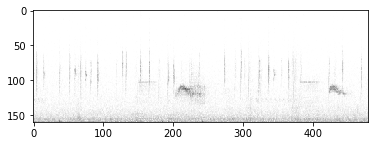

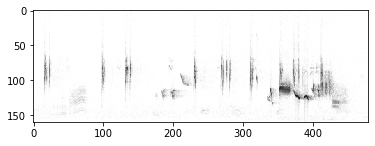

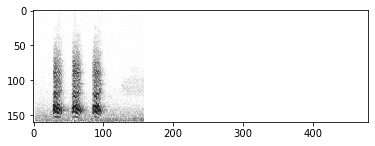

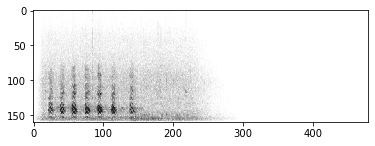

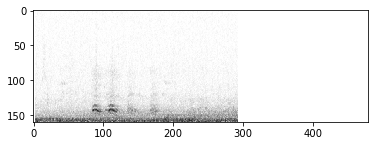

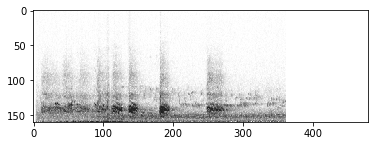

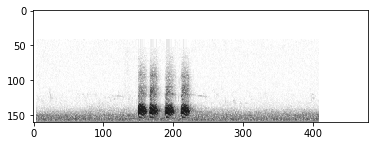

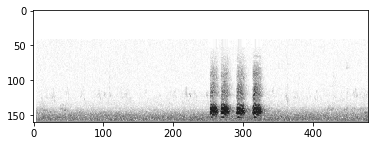

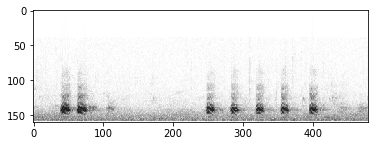

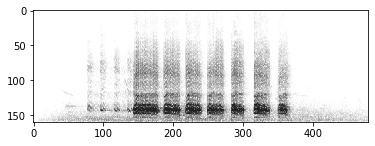

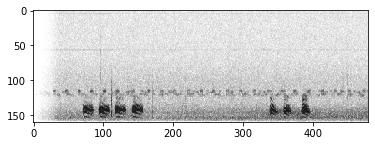

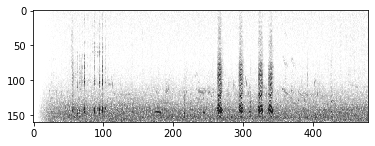

In [22]:
# #load sonograms into np array and prep for PCA for clustering
sonograms = mpimg.imread(df['sonogram_url'][0]).ravel()
print(sonograms)
for i in range(0,100):
    sonogram = mpimg.imread(df['sonogram_url'][i])
    temp = np.array(mpimg.imread(df['sonogram_url'][i])).ravel()
    sonograms = np.vstack((sonograms, temp))
    plt.imshow(sonogram)
    plt.show()
# #this errors eventually, 404 on #203, probably better to make them myself.
# def specTerp(wavData,sampleRate,startingFreq,stoppingFreq,numBins):
#     spectrum = np.fft.rfft(wavData).real
#     return spectrum
#     freqBins = np.fft.rfftfreq(2000, d=1./sampleRate)

#     desiredBins = np.logspace(startingFreq, stoppingFreq, numBins)

#     spectrumInterp = np.interp(desiredBins, freqBins, spectrum)
#     return spectrumInterp


In [ ]:
#example: 
    #sound = AudioSegment.from_mp3(fullPath(df[0]))

    # # len() and slicing are in milliseconds
    # halfway_point = len(sound) / 2
    # second_half = sound[halfway_point:]

    # # Concatenation is just adding
    # second_half_3_times = second_half + second_half + second_half

    # # writing mp3 files is a one liner
    # second_half_3_times.export("/path/to/new/file.mp3", format="mp3")
#temp = AudioSegment.from_wav(r"C:\Users\Ian\jupyter\xeno-canto-ca-nv\wavs\XC4971.wav")

# maxlength=0
# for i, sample in tqdm(df.iterrows(), total=len(df)):
#     filename = r"C:/Users/Ian/jupyter/xeno-canto-ca-nv/wavs/" + sample['file_name'].split('.')[0] + r".wav"
#     #print(filename)
#     #segment =  AudioSegment.from_wav(filename)
    
#     spf = wave.open(filename, "r")
#     # Extract Raw Audio from Wav File
#     signal = spf.readframes(-1)
#     signal = np.fromstring(signal, "Int16")
#     if maxlength < len(signal):
#         maxlength = len(signal)
# #     plt.plot(signal)
# #     plt.show()

# print(maxlength)

print(librosa.util.example_audio_file())
filename = r"c:\\Users\\ian\\Jupyter\\xeno-canto-ca-nv\\wavs\\" + df['file_name'][10].split('.')[0] + r".wav"
print(filename)
data, samplerate = librosa.core.load(filename, duration=5, sr=22050)
print(data)
temp = np.array(data)
print(temp.shape)


In [23]:
filename = r"xeno-canto-ca-nv/wavs/" + df['file_name'][0].split('.')[0] + r".wav"
samplerate , data = read_wav(filename)
#specTerps = np.array([specTerp(data.ravel(), samplerate, 200, 20000, 2000)])
songData = np.array(data)

maxlen = 0;
minlen = 7981680;
maxrate = 0;
minrate = 7981680;
lenarr = {};
ratearr = {};

SAMPLELEN=5*22050
#SAMPLELEN=5*44100
X = np.ndarray((2730,1,SAMPLELEN))

for i in range(0,len(df)):
    filename = r"xeno-canto-ca-nv/wavs/" + df['file_name'][i].split('.')[0] + r".wav"
    temp = load(filename, sr = 22050, duration=5, mono=True)[0]
    PADLEN = SAMPLELEN - len(temp) 
    if PADLEN>0:
        X[i,0, :] = np.pad(temp, (int(PADLEN/2), PADLEN - int(PADLEN/2)), mode='mean')
    else:
        X[i,0, :] = temp
    if (i%50 == 0):
        print(i)
print("done laoding")
    
# X = np.pad((songData, np.zeros))
# for i in range tqdm(range(1,len(df))):
#     filename = r"xeno-canto-ca-nv/wavs/" + df['file_name'][i].split('.')[0] + r".wav"
#     samplerate , data = read_wav(filename)
#     if len(data) < 4000:
#         padWidth = maxlen - len(data)
#         X = np.vertcat((X, np.pad(data, (np.floor(padWidth/2),np.ceil(padWidth/2)), mode='mean')))
#     else if len(data) > 4000:
#         X = 
#     else:
#         X = 
   
        
    #spectrumInterp = specTerp(data.ravel(), samplerate, 200, 20000, 2000)
    #specTerps = np.vstack((specTerps, np.hstack((spectrumInterp, data)))) 
    #songData = np.vstack((songData, data))

#print(maxlen, minlen, maxrate, minrate, filename_min)

# f = open('songData.pickle','wb')
# pickle.dump(X , f )
# f.close()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
done laoding


In [24]:
f = open('songData.pickle','wb')
pickle.dump(X , f )
f.close()
f = open('y.pickle','wb')
pickle.dump(y , f )
f.close()

1245155.3062271061

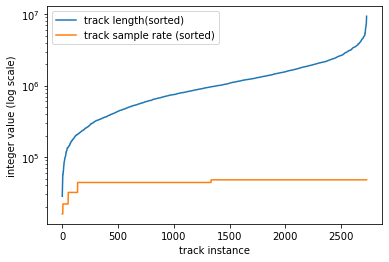

In [11]:
lenarr = {}
ratearr = {}

for i in range(0,len(df)):
    filename = r"xeno-canto-ca-nv/wavs/" + df['file_name'][i].split('.')[0] + r".wav"
    samplerate , data = read_wav(filename)
    lenarr[i] = len(data)
    ratearr[i] = samplerate
    
#show lengths of song files
ind_rate = np.argsort(np.array(list(ratearr.items()))[:, 1])
ind      = np.argsort(np.array(list(lenarr.items()))[:, 1], kind='stable')

plt.semilogy(np.array(list(lenarr.items()))[ind, 1])
plt.semilogy(np.array(list(ratearr.items()))[ind_rate, 1])
plt.legend(['track length(sorted)','track sample rate (sorted)'])
plt.xlabel('track instance')
plt.ylabel('integer value (log scale)')
plt.show
np.array(list(ratearr.items()))[ind_rate, 1][1000]
np.mean(np.array(list(lenarr.items()))[ind, 1])

In [ ]:
# k=3

# linmodel = svm.SVC(kernel='linear')
# polmodel = svm.SVC(kernel='poly')
# rbfmodel = svm.SVC(kernel='rbf')
# sigmodel = svm.SVC(kernel='sigmoid')

# y_pred_lin = cross_val_predict(linmodel, X, y, cv=k)
# y_pred_pol = cross_val_predict(polmodel, X, y, cv=k)
# y_pred_rbf = cross_val_predict(rbfmodel, X, y, cv=k)
# y_pred_sig = cross_val_predict(sigmodel, X, y, cv=k)

# print(metrics.classification_report(y, y_pred_lin))
# print(metrics.classification_report(y, y_pred_pol))
# print(metrics.classification_report(y, y_pred_rbf))
# print(metrics.classification_report(y, y_pred_sig))

# print(metrics.confusion_matrix(y, y_pred_lin))
# print(metrics.confusion_matrix(y, y_pred_pol))
# print(metrics.confusion_matrix(y, y_pred_rbf))
# print(metrics.confusion_matrix(y, y_pred_sig))

# model = DecisionTreeClassifier()
# y_pred = cross_val_predict(model, X, y, cv=k)
# print(metrics.classification_report(y, y_pred))
# print(metrics.confusion_matrix(y, y_pred))

In [ ]:
# lrclassifier = lr(random_state=42).fit(X, y)


In [ ]:
# plt.plot(X[33])

In [ ]:
# predicted = cross_val_predict(LogisticRegression(), X, y, cv=3)
# print(metrics.classification_report(y, predicted))
# print(metrics.confusion_matrix(y, predicted))

In [ ]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start

  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.config.experimental.list_physical_devices("GPU"):
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
    
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

In [1]:
import tensorflow as tf
with tf.device("CPU:0"):
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    session = tf.compat.v1.Session(config=config)
    import pickle
    import pandas as pd
    import numpy as np
    import tensorflow.keras as keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Softmax, LeakyReLU
    import tensorflow.keras.layers
    import kapre
    from kapre.time_frequency import Melspectrogram
    from kapre.utils import Normalization2D
    from kapre.augmentation import AdditiveNoise
    from sklearn.utils import shuffle

    #exponential decay learning rate
    #global_step = tf.Variable(0, trainable=False)
    #starter_learning_rate = 0.1
    #learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step=global_step, decay_steps=10000, decay_rate=0.95)

    f = open('songData.pickle','rb')
    X = pickle.load(f)
    f.close()
    f = open('y.pickle','rb')
    y = pickle.load(f)
    f.close()

    input_shape = X[1].shape
    sr = 22050
    model = Sequential()
    model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                             padding='same', sr=sr, n_mels=128,
                             fmin=0.0, fmax=sr/2, power_melgram=1.0,
                             return_decibel_melgram=False, trainable_fb=False,
                             trainable_kernel=True,
                             name='trainable_stft'))
    # Maybe some additive white noise.
    model.add(AdditiveNoise(power=0.1))
    # If you wanna normalise it per-frequency
    model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'
    model.add(Conv2D(3, 3, activation='sigmoid'))
    model.add(MaxPool2D())
    model.add(Conv2D(9, 5, activation='sigmoid'))
    model.add(MaxPool2D())
    model.add(Conv2D(3, 3, activation='tanh'))
    model.add(MaxPool2D())
    model.add(Conv2D(9, 5, activation='tanh'))
    model.add(MaxPool2D())
#     model.add(Conv2D(10, 5, activation='sigmoid'))
#     model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer="Adadelta", loss='CategoricalCrossentropy', metrics=['accuracy']) # if single-label classification
    
# train it with raw audio sample inputs
with tf.device("GPU:0"):
    X,y = shuffle(X,y,random_state=42)
    model.fit(X, y, epochs = 20, validation_split=0.3)
    print(model.predict(X[:6, :, :]))
    # Done!
session = tf.compat.v1.Session(config=config)

c:\users\ian\appdata\local\programs\python\python38\lib\site-packages\librosa\filters.py:194: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  warnings.warn('norm=1 behavior will change in librosa 0.8.0. '


Epoch 1/20
60/60 [==============================] - 3s 58ms/step - loss: 0.9859 - accuracy: 0.4346 - val_loss: 0.9852 - val_accuracy: 0.4122
Epoch 2/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9790 - accuracy: 0.4346 - val_loss: 0.9782 - val_accuracy: 0.4122
Epoch 3/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9723 - accuracy: 0.4346 - val_loss: 0.9713 - val_accuracy: 0.4122
Epoch 4/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9658 - accuracy: 0.4346 - val_loss: 0.9646 - val_accuracy: 0.4122
Epoch 5/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9595 - accuracy: 0.4346 - val_loss: 0.9581 - val_accuracy: 0.4122
Epoch 6/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9534 - accuracy: 0.4346 - val_loss: 0.9519 - val_accuracy: 0.4122
Epoch 7/20
60/60 [==============================] - 3s 46ms/step - loss: 0.9474 - accuracy: 0.4346 - val_loss: 0.9458 - val_accuracy: 0.4122
Epoch 8/20
60

In [13]:
print(model.predict(X[:1, :, :]))
print(y[0,:2])

[[0.41231906 0.3020755  0.28560546]]
[0 1 0]


In [ ]:
session = tf.compat.v1.Session(config=config)

In [20]:
np.ndarray((2,3,4)).shape
np.reshape(np.ndarray((2,3,4)), (4,3,2)).shape

(4, 3, 2)